# ★Chapter8：インフォグラフィックのビジュアライゼーション

## ●04 インフォグラフィックで用いるライブラリ

リスト8.1　pillowのインポート

In [1]:
from PIL import Image, ImageOps
from IPython.display import display

## ●05 画像の大きさで数量を表現する

リスト8.2　画像の読み込みと描画の例

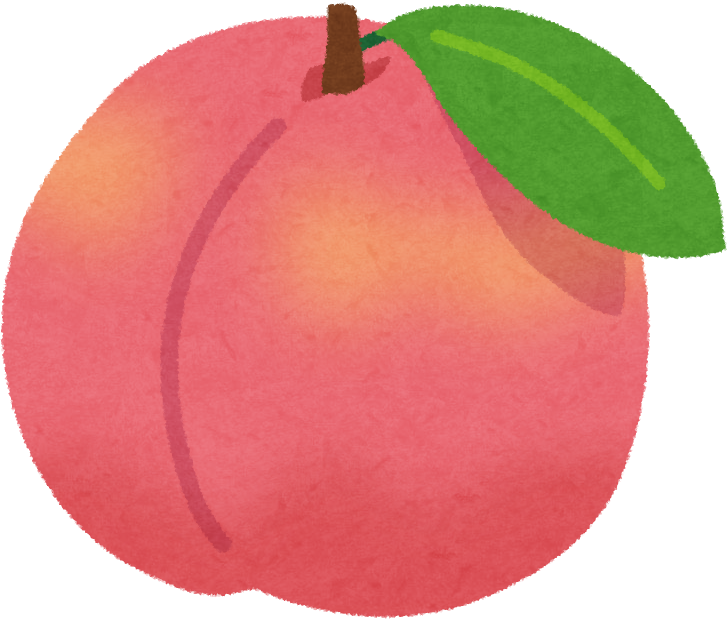

In [2]:
im = Image.open("fruit_momo.png")
display(im)

リスト8.3　画像の大きさを変更した例

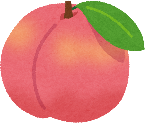

(145, 123)


In [3]:
mini_im = im.resize((int(im.size[0] * 0.2), int(im.size[1] * 0.2)))
display(mini_im)
print(mini_im.size)

## ●06　並べる個数で数量を表現する

リスト8.4　人の画像の数で数量を表現する例

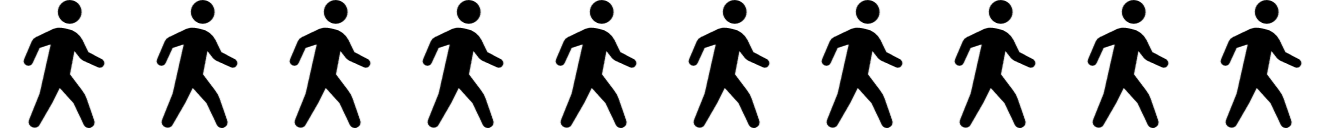

In [4]:
# 並べる個数
num = 10

# 画像間のマージン
margin = 5

# 画像の読み込み
im = Image.open("human.png")
im_width, im_height = im.size

# 土台となるImageに読み込んだ画像を貼り付けていく
canvas = Image.new("RGBA", ((im_width + margin) * num, im_height))
for i in range(num):
    canvas.paste(im, ((im_width + margin) * i, 0))

canvas

リスト8.5　画像が多い場合は区切りの良い箇所で折り返す

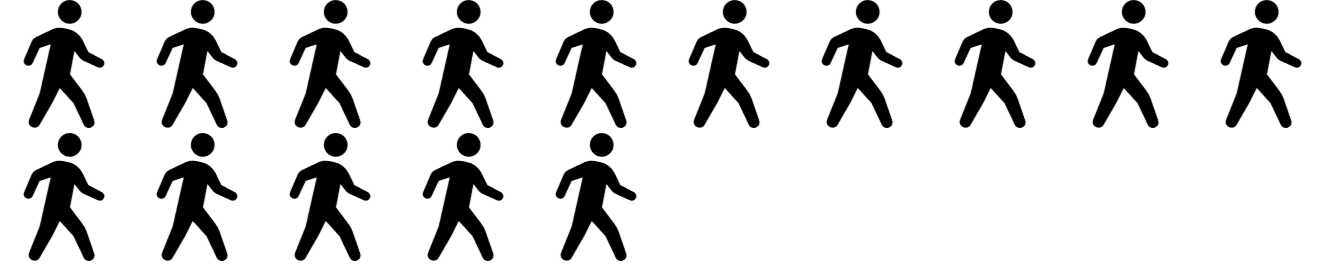

In [5]:
import math

# 並べる個数
num = 15

# 折り返す個数
wrap_num = 10

# 画像間のマージン
margin_h = 5
margin_v = 5

# 画像の読み込み
im = Image.open("human.png")
im_width, im_height = im.size

# 土台となるImageに読み込んだ画像を貼り付けていく
canvas = Image.new("RGBA", ((im_width + margin_h) * wrap_num, 
                            (im_height + margin_v) * math.ceil(num / wrap_num)))
for i in range(num):
    x = (im_width + margin_h) * (i % wrap_num)
    y = (im_height + margin_v) * (i // wrap_num)
    canvas.paste(im, (x, y))

canvas

## ●07　割合を画像で表現する

リスト8.6　画像の読み込み

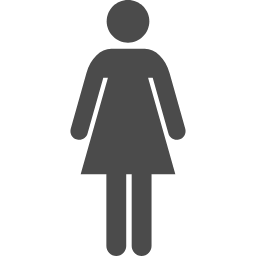

In [6]:
from PIL import Image, ImageOps
from IPython.display import display

im = Image.open("woman.png")
display(im)

リスト8.7　1つの画像の中の色で割合を表現する例

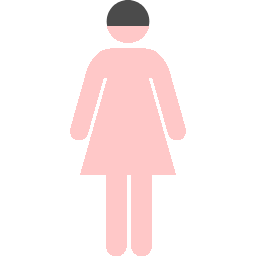

In [7]:
def fill(image, percentage=100):
    start = int(image.size[1] / 100 * percentage)
    for y in range(image.size[1] - start, image.size[1]):
        for x in range(image.size[0]):
            if image.getpixel((x, y))[3] != 0:
                image.putpixel((x, y), (255, 200, 200))
                
fill(im, 90)
display(im)

リスト8.8　複数の色の違う画像で割合を表現する例

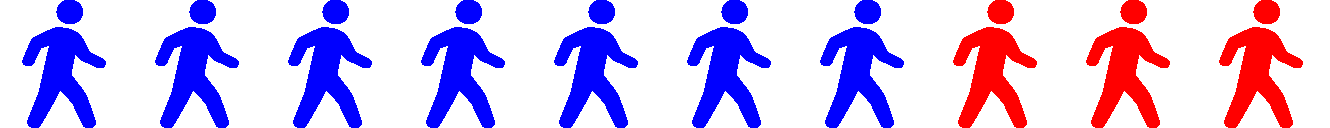

In [8]:
# 並べる個数
num = 10

# 画像間のマージン
margin = 5

# 画像を指定の色で塗りつぶす関数
def fill(image, color=(255, 255, 255)):
    for y in range(image.size[1]):
        for x in range(image.size[0]):
            if image.getpixel((x, y))[3] != 0:
                image.putpixel((x, y), color)
                
# 画像を読み込み
im = Image.open("human.png")
im_width, im_height = im.size

# 土台となるImageに読み込んだ画像を貼り付けていく
canvas = Image.new("RGBA", ((im_width + margin) * num, im_height))
for i in range(num):
    if i < 7:
        # 7個目までは青を指定
        color = (0, 0, 255)
    else:
        # それ以降は赤を指定
        color = (255, 0, 0)
        
 # 指定した色で塗りつぶす
    color_im = im.copy()
    fill(color_im, color)
    
    # 貼り付け
    canvas.paste(color_im, ((im_width + margin) * i, 0))
    
canvas

## ●08 縦棒グラフのように画像を並べる

リスト8.9　グラフを描画するクラスを定義

In [9]:
from PIL import Image, ImageDraw, ImageFont

class IconGraph:
    # 初期化用
    def __init__(self, data, icon_size=(128, 128), size=(800, 800),
                 back_color=(255, 255, 255), 
                 label_back_color=(255, 255, 255),
                 font="C:\Windows\Fonts\meiryo.ttc", 
                 font_size=24, font_color=(0, 0, 0)):
        
        self.canvas_size = [size[0], size[1]]  # 全体のサイズ
        self.label_field_height = 100  # ラベル描画領域の高さ
        # グラフ描画領域のサイズ
        self.graph_size = [self.canvas_size[0], 
                           self.canvas_size[1] - self.label_field_height]
        self.icon_size = icon_size  # アイコンのサイズ
        self.back_color = back_color # グラフ描画領域の背景色
        self.label_back_color = label_back_color  # ラベル描画領域の背景色
            
        # ラベル情報をセット
        self.labels = []
        for d in data:
            self.labels.append(d["label"])
              
        # valueの最大値を取得
        value_max = data[0]["value"]
        for d in data:
            if value_max < d["value"]:
                value_max = d["value"]
        
        # セルの個数
        self.grid_y = value_max  # セルの個数（縦）
        self.grid_x = len(data)  # セルの個数（横）
        
        # セルの大きさ
        # 1セルが使用できる高さ
        self.grid_height = self.icon_size[1]  
        # 1セルが使用できる幅
        self.grid_width = self.graph_size[0] // self.grid_x
        
        # セルの中心までのオフセット
        self.grid_med_offset = (self.grid_width // 2, self.grid_height // 2)  
        
        # グラフ描画領域の高さが足りない場合は自動拡張
        if self.graph_size[1] < self.grid_height * self.grid_y:
            self.graph_size[1] = self.grid_height * self.grid_y
            self.canvas_size[1] = self.grid_height * self.grid_y \
                                  + self.label_field_height
        
        # グリッドを構成
        self.grid = [[None for i in range(self.grid_y)] \
                     for j in range(self.grid_x)]
        
        # グリッドに画像を登録
        for x in range(len(data)):
            target = data[x]
            icon = Image.open(target["image"])
            for j in range(target["value"]):
                self.grid[x][j] = icon
        
        # ラベルのフォント設定
        self.font = ImageFont.truetype(font, font_size)
        self.font_color = font_color
        
        # 描画
        self._draw()

        
    # グラフを描画する
    def _draw(self):
        # キャンバスとグラフ描画領域を生成
        self.canvas = Image.new("RGBA", self.canvas_size, self.label_back_color)
        self.graph_field = Image.new("RGBA", self.graph_size, self.back_color)
        
        # グラフ描画領域にアイコンを描画
        for x in range(len(self.grid)):
            # 描画位置の計算
            x_offset = x * self.grid_width  # 描画するセルの左端の座標
            
            # ラベルを描画
            imd = ImageDraw.Draw(self.canvas)
            # ラベルのサイズを計算
            label_size = imd.textsize(self.labels[x], self.font)  
            # ラベルの左端の座標
            label_x = x_offset + self.grid_med_offset[0] - label_size[0] // 2  
            
            imd.text((label_x, self.graph_size[1]), self.labels[x], 
                     font=self.font, fill=self.font_color)
            
            # アイコンを描画
            for y in range(len(self.grid[x])):
                if self.grid[x][y] is None:
                    continue
                c_x = x_offset + self.grid_med_offset[0] \
                      - self.icon_size[0] // 2  # アイコンの左端の座標
                c_y = self.graph_size[1] - (y * self.grid_height) \
                      - self.grid_height  # アイコンの上端の座標
                self.graph_field.paste(self.grid[x][y],
                                       (c_x, c_y), 
                                       self.grid[x][y])
        
        # グラフ描画領域をキャンバスに貼り付ける
        self.canvas.paste(self.graph_field)

    
    # グラフ画像を返す
    def get_image(self):
        return self.canvas

リスト8.10　画像を使った縦棒グラフの描画例

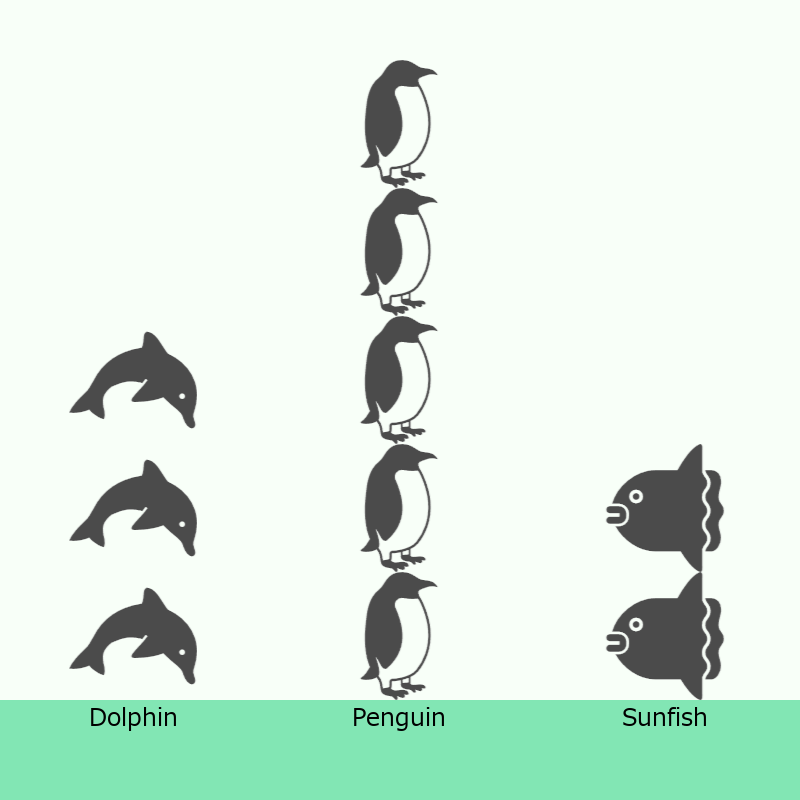

In [10]:
# アイコンのサイズは統一されているものとする
# アイコン画像のサイズ
icon_size = (128, 128)

# グラフ全体のサイズ（グラフの高さに関しては自動で拡張される）
canvas_size = (800, 800)

# グラフ描画領域の背景色
graph_back_color = (248, 255, 248)

# ラベル描画領域の背景色
label_back_color = (130, 230, 180)

# データ定義
data = [
    {
        "label": "Dolphin",  # ラベル
        "image": "dolphin.png",  # 積み上げる画像
        "value": 3  # 積み上げる個数
    },
    {
        "label": "Penguin",
        "image": "penguin.png",
        "value": 5
    },
    {
        "label": "Sunfish",
        "image": "sunfish.png",
        "value": 2
    },
]


ig = IconGraph(data, icon_size, canvas_size, graph_back_color, label_back_color)
ig.get_image()